In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import cv2
import pickle
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("\n✓ All libraries imported successfully!")

TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✓ All libraries imported successfully!


Set Random Seeds for Reproducibility

In [23]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed(42)
print("✓ Random seeds set for reproducibility")

✓ Random seeds set for reproducibility


Define Paths and Configuration

In [24]:
# Define paths
PROCESSED_DATA_PATH = '/content/drive/MyDrive/brain-tumor-classification/data/processed'
MODEL_SAVE_PATH = '/content/drive/MyDrive/brain-tumor-classification/models'

# Create model directory if it doesn't exist
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Configuration
IMG_SIZE = 224  # VGG16 requires 224x224 input
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
VALIDATION_SPLIT = 0.2  # 20% of training data for validation

# Class names
CLASS_NAMES = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
NUM_CLASSES = len(CLASS_NAMES)

print("Configuration:")
print("="*60)
print(f"Processed Data Path: {PROCESSED_DATA_PATH}")
print(f"Model Save Path: {MODEL_SAVE_PATH}")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Validation Split: {VALIDATION_SPLIT}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")

Configuration:
Processed Data Path: /content/drive/MyDrive/brain-tumor-classification/data/processed
Model Save Path: /content/drive/MyDrive/brain-tumor-classification/models
Image Size: 224x224
Batch Size: 32
Epochs: 50
Learning Rate: 0.0001
Validation Split: 0.2
Number of Classes: 4
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


Load and Prepare Data

In [25]:
def load_data_from_directory(data_path, split='Training'):
    """
    Load images and labels from directory
    """
    images = []
    labels = []

    split_path = os.path.join(data_path, split)

    print(f"\nLoading {split} data...")
    print("="*60)

    for idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(split_path, class_name)

        if not os.path.exists(class_path):
            print(f"Warning: {class_path} does not exist!")
            continue

        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        print(f"Loading {class_name}: {len(image_files)} images")

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)

            # Read image
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                images.append(img)
                labels.append(idx)

    return np.array(images), np.array(labels)

# Load training and testing data
X_train_full, y_train_full = load_data_from_directory(PROCESSED_DATA_PATH, 'Training')
X_test, y_test = load_data_from_directory(PROCESSED_DATA_PATH, 'Testing')

print("\n" + "="*60)
print("Data Loading Summary:")
print("="*60)
print(f"Training data shape: {X_train_full.shape}")
print(f"Training labels shape: {y_train_full.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")


Loading Training data...
Loading glioma_tumor: 826 images
Loading meningioma_tumor: 822 images
Loading no_tumor: 395 images
Loading pituitary_tumor: 827 images

Loading Testing data...
Loading glioma_tumor: 100 images
Loading meningioma_tumor: 115 images
Loading no_tumor: 105 images
Loading pituitary_tumor: 74 images

Data Loading Summary:
Training data shape: (2870, 224, 224, 3)
Training labels shape: (2870,)
Testing data shape: (394, 224, 224, 3)
Testing labels shape: (394,)


Split Training Data into Train and Validation

In [26]:
# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VALIDATION_SPLIT,
    random_state=42,
    stratify=y_train_full
)

print("\n" + "="*60)
print("Data Split Summary:")
print("="*60)
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Testing set: {X_test.shape[0]} images")

# Display class distribution
print("\n" + "="*60)
print("Class Distribution:")
print("="*60)

for split_name, split_labels in [('Training', y_train), ('Validation', y_val), ('Testing', y_test)]:
    print(f"\n{split_name} Set:")
    for idx, class_name in enumerate(CLASS_NAMES):
        count = np.sum(split_labels == idx)
        percentage = (count / len(split_labels)) * 100
        print(f"  {class_name:25s}: {count:4d} ({percentage:5.2f}%)")


Data Split Summary:
Training set: 2296 images
Validation set: 574 images
Testing set: 394 images

Class Distribution:

Training Set:
  glioma_tumor             :  661 (28.79%)
  meningioma_tumor         :  657 (28.61%)
  no_tumor                 :  316 (13.76%)
  pituitary_tumor          :  662 (28.83%)

Validation Set:
  glioma_tumor             :  165 (28.75%)
  meningioma_tumor         :  165 (28.75%)
  no_tumor                 :   79 (13.76%)
  pituitary_tumor          :  165 (28.75%)

Testing Set:
  glioma_tumor             :  100 (25.38%)
  meningioma_tumor         :  115 (29.19%)
  no_tumor                 :  105 (26.65%)
  pituitary_tumor          :   74 (18.78%)


Normalize Data

In [27]:
# Normalize pixel values to [0, 1] range
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print("✓ Data normalized to [0, 1] range")
print(f"Training data range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"Validation data range: [{X_val.min():.3f}, {X_val.max():.3f}]")
print(f"Testing data range: [{X_test.min():.3f}, {X_test.max():.3f}]")

✓ Data normalized to [0, 1] range
Training data range: [0.000, 1.000]
Validation data range: [0.000, 1.000]
Testing data range: [0.000, 1.000]


Convert Labels to One-Hot Encoding

In [28]:
# Convert labels to one-hot encoding
y_train_categorical = to_categorical(y_train, NUM_CLASSES)
y_val_categorical = to_categorical(y_val, NUM_CLASSES)
y_test_categorical = to_categorical(y_test, NUM_CLASSES)

print("✓ Labels converted to one-hot encoding")
print(f"Training labels shape: {y_train_categorical.shape}")
print(f"Validation labels shape: {y_val_categorical.shape}")
print(f"Testing labels shape: {y_test_categorical.shape}")

# Display sample one-hot encoding
print(f"\nSample label: {y_train[0]} ({CLASS_NAMES[y_train[0]]})")
print(f"One-hot encoded: {y_train_categorical[0]}")

✓ Labels converted to one-hot encoding
Training labels shape: (2296, 4)
Validation labels shape: (574, 4)
Testing labels shape: (394, 4)

Sample label: 0 (glioma_tumor)
One-hot encoded: [1. 0. 0. 0.]


Calculate Class Weights

In [29]:
# Calculate class weights for handling imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

print("\n" + "="*60)
print("Class Weights (for handling imbalance):")
print("="*60)
for idx, class_name in enumerate(CLASS_NAMES):
    print(f"{class_name:25s}: {class_weight_dict[idx]:.4f}")

print("\nThese weights will be used during training to handle class imbalance.")


Class Weights (for handling imbalance):
glioma_tumor             : 0.8684
meningioma_tumor         : 0.8737
no_tumor                 : 1.8165
pituitary_tumor          : 0.8671

These weights will be used during training to handle class imbalance.


Data Augmentation Setup

In [30]:
# Create data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test data
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

print("✓ Data augmentation configured")
print("\nAugmentation parameters:")
print("  • Rotation: ±15 degrees")
print("  • Width shift: ±10%")
print("  • Height shift: ±10%")
print("  • Shear: ±10%")
print("  • Zoom: ±10%")
print("  • Horizontal flip: Yes")

✓ Data augmentation configured

Augmentation parameters:
  • Rotation: ±15 degrees
  • Width shift: ±10%
  • Height shift: ±10%
  • Shear: ±10%
  • Zoom: ±10%
  • Horizontal flip: Yes


Visualize Augmented Images

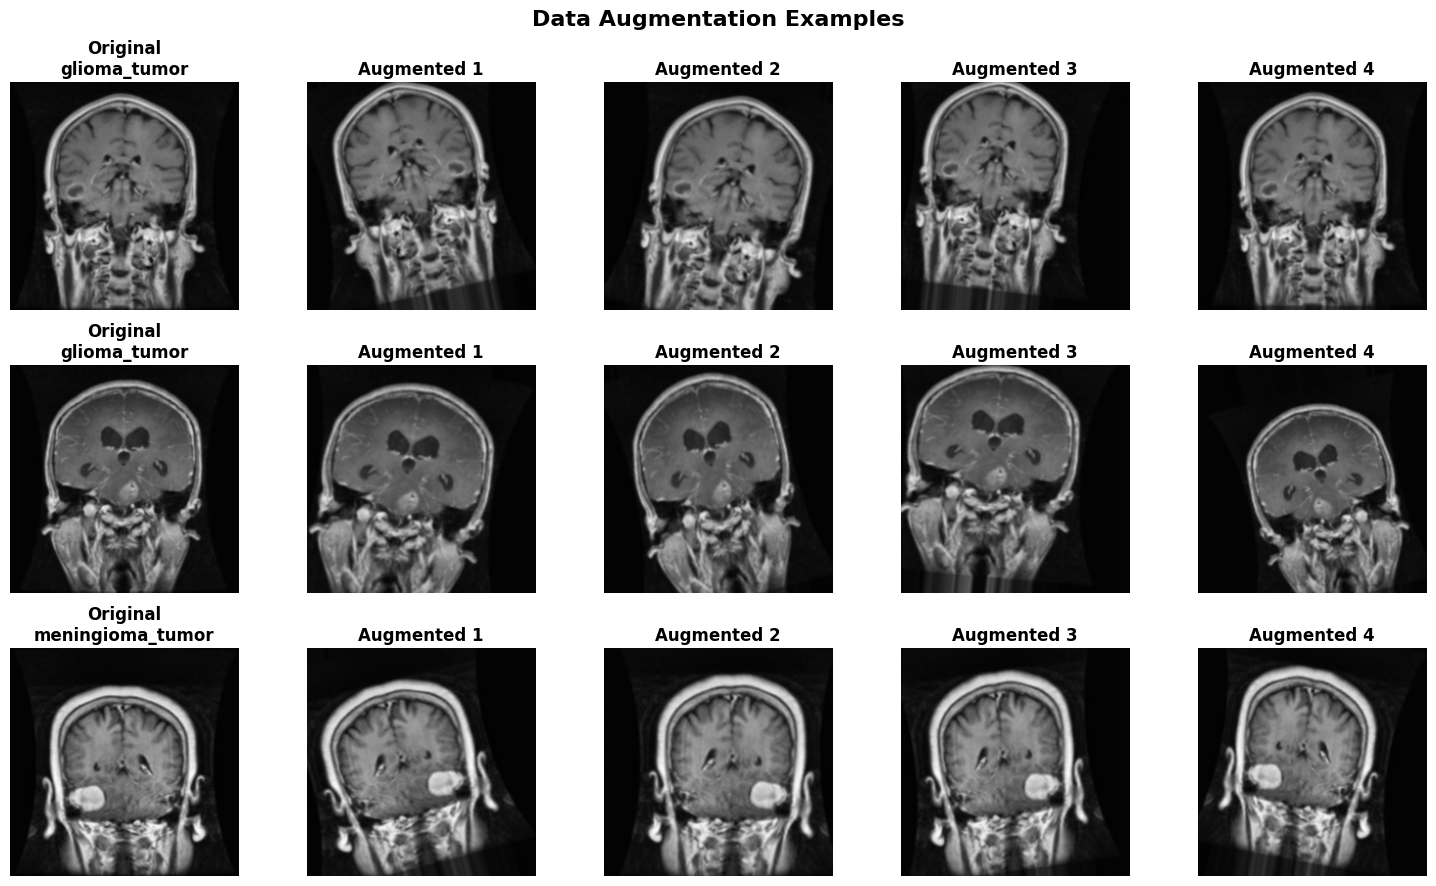

In [31]:
# Visualize augmented images
def visualize_augmentation(X, y, num_samples=3):
    """
    Visualize original and augmented images
    """
    fig, axes = plt.subplots(num_samples, 5, figsize=(15, 3*num_samples))
    fig.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')

    # Select random samples
    sample_indices = np.random.choice(len(X), num_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        img = X[idx]
        label = CLASS_NAMES[y[idx]]

        # Original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original\n{label}', fontweight='bold')
        axes[i, 0].axis('off')

        # Generate augmented versions
        img_augmented = img.reshape((1,) + img.shape)
        aug_iter = train_datagen.flow(img_augmented, batch_size=1)

        for j in range(1, 5):
            aug_img = next(aug_iter)[0]
            axes[i, j].imshow(aug_img)
            axes[i, j].set_title(f'Augmented {j}', fontweight='bold')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize augmentation
visualize_augmentation(X_train, y_train, num_samples=3)

Build VGG16 Model

In [32]:
def build_vgg16_model(input_shape=(224, 224, 3), num_classes=4):
    """
    Build VGG16 model with custom top layers for brain tumor classification
    """
    # Load pre-trained VGG16 model without top layers
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        name='vgg16'  # Add explicit name
    )

    # Freeze the base model layers initially
    base_model.trainable = False

    # Build custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = BatchNormalization(name='bn1')(x)
    x = Dense(512, activation='relu', name='dense1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Dense(256, activation='relu', name='dense2')(x)
    x = Dropout(0.3, name='dropout2')(x)
    x = Dense(num_classes, activation='softmax', name='output')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=x, name='vgg16_brain_tumor')

    return model

# Build the model
print("Building VGG16 model...")
print("="*60)

model = build_vgg16_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)

print("✓ Model built successfully!")
print(f"\nModel input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")

Building VGG16 model...
✓ Model built successfully!

Model input shape: (None, 224, 224, 3)
Model output shape: (None, 4)


Display Model Summary

In [33]:
# Display model summary
print("\n" + "="*60)
print("VGG16 MODEL ARCHITECTURE")
print("="*60)

model.summary()

# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print("\n" + "="*60)
print("Model Parameters Summary:")
print("="*60)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")


VGG16 MODEL ARCHITECTURE


Model: "vgg16_brain_tumor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,113,796 (57.65 MB)

 Trainable params: 397,060 (1.51 MB)

 Non-trainable params: 14,716,736 (56.14 MB)


Model Parameters Summary:
Total parameters: 15,113,796
Trainable parameters: 397,060
Non-trainable parameters: 14,716,736


Compile Model

In [34]:
# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("✓ Model compiled successfully!")
print("\nCompilation settings:")
print(f"  • Optimizer: Adam")
print(f"  • Learning Rate: {LEARNING_RATE}")
print(f"  • Loss: categorical_crossentropy")
print(f"  • Metrics: accuracy, precision, recall")

✓ Model compiled successfully!

Compilation settings:
  • Optimizer: Adam
  • Learning Rate: 0.0001
  • Loss: categorical_crossentropy
  • Metrics: accuracy, precision, recall


Setup Callbacks

In [35]:
# Setup callbacks
callbacks = []

# 1. Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
callbacks.append(early_stopping)

# 2. Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)
callbacks.append(reduce_lr)

# 3. Model Checkpoint (save best model during training)
checkpoint_path = os.path.join(MODEL_SAVE_PATH, 'vgg16_best_checkpoint.h5')
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
callbacks.append(model_checkpoint)

print("✓ Callbacks configured:")
print("  • Early Stopping (patience=10)")
print("  • Reduce Learning Rate on Plateau (patience=5)")
print("  • Model Checkpoint (saving best model)")

✓ Callbacks configured:
  • Early Stopping (patience=10)
  • Reduce Learning Rate on Plateau (patience=5)
  • Model Checkpoint (saving best model)


Train the Model (Phase 1 - Frozen Base)

In [36]:
# Train the model with frozen base
print("\n" + "="*60)
print("TRAINING PHASE 1: Frozen VGG16 Base")
print("="*60)
print("Training only the custom top layers...")

history_phase1 = model.fit(
    train_datagen.flow(X_train, y_train_categorical, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=20,  # Initial training for 20 epochs
    validation_data=(X_val, y_val_categorical),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Phase 1 training completed!")


TRAINING PHASE 1: Frozen VGG16 Base
Training only the custom top layers...
Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.3099 - loss: 1.7096 - precision_1: 0.3102 - recall_1: 0.2138
Epoch 1: val_accuracy improved from -inf to 0.40767, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 512ms/step - accuracy: 0.3111 - loss: 1.7063 - precision_1: 0.3116 - recall_1: 0.2148 - val_accuracy: 0.4077 - val_loss: 1.2662 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 46s 670ms/step - accuracy: 0.6250 - loss: 1.1372 - precision_1: 0.6296 - recall_1: 0.5312
Epoch 2: val_accuracy did not improve from 0.40767
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6250 - loss: 1.1372 - precision_1: 0.6296 - recall_1: 0.5312 - val_accuracy: 0.4077 - val_loss: 1.2643 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.5508 - loss: 1.0626 - precision_1: 0.6149 - recall_1: 0.4555
Epoch 3: val_accuracy improved from 0.40767 to 0.59930, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 517ms/step - accuracy: 0.5513 - loss: 1.0619 - precision_1: 0.6154 - recall_1: 0.4560 - val_accuracy: 0.5993 - val_loss: 1.1267 - val_precision_1: 0.9375 - val_recall_1: 0.0261 - learning_rate: 1.0000e-04
Epoch 4/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 31s 447ms/step - accuracy: 0.5938 - loss: 0.6605 - precision_1: 0.7500 - recall_1: 0.5625
Epoch 4: val_accuracy improved from 0.59930 to 0.60453, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5938 - loss: 0.6605 - precision_1: 0.7500 - recall_1: 0.5625 - val_accuracy: 0.6045 - val_loss: 1.1247 - val_precision_1: 0.9412 - val_recall_1: 0.0279 - learning_rate: 1.0000e-04
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6678 - loss: 0.8343 - precision_1: 0.7143 - recall_1: 0.6019
Epoch 5: val_accuracy improved from 0.60453 to 0.68815, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 518ms/step - accuracy: 0.6677 - loss: 0.8345 - precision_1: 0.7142 - recall_1: 0.6017 - val_accuracy: 0.6882 - val_loss: 0.9487 - val_precision_1: 0.9245 - val_recall_1: 0.2561 - learning_rate: 1.0000e-04
Epoch 6/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 30s 438ms/step - accuracy: 0.6250 - loss: 0.9454 - precision_1: 0.6250 - recall_1: 0.4688
Epoch 6: val_accuracy improved from 0.68815 to 0.69164, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6250 - loss: 0.9454 - precision_1: 0.6250 - recall_1: 0.4688 - val_accuracy: 0.6916 - val_loss: 0.9461 - val_precision_1: 0.9264 - val_recall_1: 0.2631 - learning_rate: 1.0000e-04
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.6876 - loss: 0.7661 - precision_1: 0.7373 - recall_1: 0.6255
Epoch 7: val_accuracy improved from 0.69164 to 0.74564, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 516ms/step - accuracy: 0.6877 - loss: 0.7660 - precision_1: 0.7373 - recall_1: 0.6257 - val_accuracy: 0.7456 - val_loss: 0.7790 - val_precision_1: 0.8860 - val_recall_1: 0.5279 - learning_rate: 1.0000e-04
Epoch 8/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 31s 445ms/step - accuracy: 0.7500 - loss: 0.6262 - precision_1: 0.7742 - recall_1: 0.7500
Epoch 8: val_accuracy did not improve from 0.74564
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7500 - loss: 0.6262 - precision_1: 0.7742 - recall_1: 0.7500 - val_accuracy: 0.7456 - val_loss: 0.7771 - val_precision_1: 0.8860 - val_recall_1: 0.5279 - learning_rate: 1.0000e-04
Epoch 9/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7244 - loss: 0.6920 - precision_1: 0.7667 - recall_1: 0.6784
Epoch 9: val_accuracy improved from 0.74564 to 0.78223, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 521ms/step - accuracy: 0.7244 - loss: 0.6923 - precision_1: 0.7666 - recall_1: 0.6783 - val_accuracy: 0.7822 - val_loss: 0.6504 - val_precision_1: 0.8591 - val_recall_1: 0.6690 - learning_rate: 1.0000e-04
Epoch 10/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 30s 431ms/step - accuracy: 0.6875 - loss: 0.7970 - precision_1: 0.7000 - recall_1: 0.6562
Epoch 10: val_accuracy did not improve from 0.78223
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6875 - loss: 0.7970 - precision_1: 0.7000 - recall_1: 0.6562 - val_accuracy: 0.7805 - val_loss: 0.6491 - val_precision_1: 0.8587 - val_recall_1: 0.6672 - learning_rate: 1.0000e-04
Epoch 11/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.7206 - loss: 0.7035 - precision_1: 0.7554 - recall_1: 0.6762
Epoch 11: val_accuracy improved from 0.78223 to 0.78746, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 521ms/step - accuracy: 0.7206 - loss: 0.7034 - precision_1: 0.7554 - recall_1: 0.6762 - val_accuracy: 0.7875 - val_loss: 0.5643 - val_precision_1: 0.8463 - val_recall_1: 0.7195 - learning_rate: 1.0000e-04
Epoch 12/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 32s 463ms/step - accuracy: 0.8125 - loss: 0.6629 - precision_1: 0.8214 - recall_1: 0.7188
Epoch 12: val_accuracy improved from 0.78746 to 0.78920, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8125 - loss: 0.6629 - precision_1: 0.8214 - recall_1: 0.7188 - val_accuracy: 0.7892 - val_loss: 0.5635 - val_precision_1: 0.8460 - val_recall_1: 0.7178 - learning_rate: 1.0000e-04
Epoch 13/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.7488 - loss: 0.6607 - precision_1: 0.7873 - recall_1: 0.7086
Epoch 13: val_accuracy improved from 0.78920 to 0.80488, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 555ms/step - accuracy: 0.7487 - loss: 0.6605 - precision_1: 0.7873 - recall_1: 0.7084 - val_accuracy: 0.8049 - val_loss: 0.5205 - val_precision_1: 0.8421 - val_recall_1: 0.7526 - learning_rate: 1.0000e-04
Epoch 14/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 30s 441ms/step - accuracy: 0.6875 - loss: 0.8196 - precision_1: 0.6897 - recall_1: 0.6250
Epoch 14: val_accuracy did not improve from 0.80488
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6875 - loss: 0.8196 - precision_1: 0.6897 - recall_1: 0.6250 - val_accuracy: 0.8049 - val_loss: 0.5204 - val_precision_1: 0.8421 - val_recall_1: 0.7526 - learning_rate: 1.0000e-04
Epoch 15/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7514 - loss: 0.6212 - precision_1: 0.7926 - recall_1: 0.7183
Epoch 15: val_accuracy did not improve from 0.80488
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 512ms/step - accuracy: 0.7514 - loss: 0.6211 - precision_1: 0.7926 - recall_1: 0.7184 - val_accuracy: 0.7997 - val_loss: 0.4976 - val_prec

71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 520ms/step - accuracy: 0.7547 - loss: 0.5843 - precision_1: 0.7889 - recall_1: 0.7129 - val_accuracy: 0.8153 - val_loss: 0.4887 - val_precision_1: 0.8493 - val_recall_1: 0.7857 - learning_rate: 1.0000e-04
Epoch 18/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 32s 464ms/step - accuracy: 0.8125 - loss: 0.4181 - precision_1: 0.8667 - recall_1: 0.8125
Epoch 18: val_accuracy improved from 0.81533 to 0.81882, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8125 - loss: 0.4181 - precision_1: 0.8667 - recall_1: 0.8125 - val_accuracy: 0.8188 - val_loss: 0.4885 - val_precision_1: 0.8493 - val_recall_1: 0.7857 - learning_rate: 1.0000e-04
Epoch 19/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7746 - loss: 0.5843 - precision_1: 0.7991 - recall_1: 0.7420
Epoch 19: val_accuracy improved from 0.81882 to 0.82230, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 534ms/step - accuracy: 0.7745 - loss: 0.5844 - precision_1: 0.7991 - recall_1: 0.7419 - val_accuracy: 0.8223 - val_loss: 0.4816 - val_precision_1: 0.8413 - val_recall_1: 0.7944 - learning_rate: 1.0000e-04
Epoch 20/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 30s 438ms/step - accuracy: 0.7812 - loss: 0.4346 - precision_1: 0.8000 - recall_1: 0.7500
Epoch 20: val_accuracy improved from 0.82230 to 0.82404, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7812 - loss: 0.4346 - precision_1: 0.8000 - recall_1: 0.7500 - val_accuracy: 0.8240 - val_loss: 0.4817 - val_precision_1: 0.8413 - val_recall_1: 0.7944 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 19.

✓ Phase 1 training completed!


Fine-tuning (Phase 2 - Unfreeze Some Layers)

In [38]:
# Fine-tuning: Unfreeze the last few layers of VGG16
print("\n" + "="*60)
print("TRAINING PHASE 2: Fine-tuning VGG16")
print("="*60)
print("Unfreezing the last convolutional block of VGG16...")

# Get all VGG16 convolutional layers (block5)
# The last convolutional block is block5: block5_conv1, block5_conv2, block5_conv3
vgg16_layers = [layer.name for layer in model.layers if 'block' in layer.name]
print(f"✓ Found {len(vgg16_layers)} VGG16 layers")

# Unfreeze only the last convolutional block (block5)
for layer in model.layers:
    if 'block5' in layer.name:
        layer.trainable = True
        print(f"  ✓ Unfroze: {layer.name}")
    elif 'block' in layer.name:
        layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE/10),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print(f"\n✓ Model recompiled with learning rate: {LEARNING_RATE/10}")

# Count trainable parameters after unfreezing
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
total_params = model.count_params()
print(f"✓ Trainable parameters now: {trainable_params:,} / {total_params:,}")

# Continue training
history_phase2 = model.fit(
    train_datagen.flow(X_train, y_train_categorical, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val_categorical),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Phase 2 training completed!")


TRAINING PHASE 2: Fine-tuning VGG16
Unfreezing the last convolutional block of VGG16...
✓ Found 18 VGG16 layers
  ✓ Unfroze: block5_conv1
  ✓ Unfroze: block5_conv2
  ✓ Unfroze: block5_conv3
  ✓ Unfroze: block5_pool

✓ Model recompiled with learning rate: 1e-05
✓ Trainable parameters now: 7,476,484 / 15,113,796
Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.7949 - loss: 0.5138 - precision_2: 0.8243 - recall_2: 0.7677
Epoch 1: val_accuracy improved from 0.82404 to 0.85366, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 571ms/step - accuracy: 0.7949 - loss: 0.5141 - precision_2: 0.8241 - recall_2: 0.7676 - val_accuracy: 0.8537 - val_loss: 0.4585 - val_precision_2: 0.8595 - val_recall_2: 0.8310 - learning_rate: 1.0000e-05
Epoch 2/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 32s 464ms/step - accuracy: 0.9062 - loss: 0.2860 - precision_2: 0.9643 - recall_2: 0.8438
Epoch 2: val_accuracy did not improve from 0.85366
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9062 - loss: 0.2860 - precision_2: 0.9643 - recall_2: 0.8438 - val_accuracy: 0.8537 - val_loss: 0.4574 - val_precision_2: 0.8600 - val_recall_2: 0.8345 - learning_rate: 1.0000e-05
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7907 - loss: 0.5218 - precision_2: 0.8121 - recall_2: 0.7652
Epoch 3: val_accuracy did not improve from 0.85366
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 535ms/step - accuracy: 0.7908 - loss: 0.5214 - precision_2: 0.8122 - recall_2: 0.7653 - val_accuracy: 0.8397 - val_loss: 0.4307 - val_precisio

71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 553ms/step - accuracy: 0.8434 - loss: 0.4000 - precision_2: 0.8712 - recall_2: 0.8259 - val_accuracy: 0.8693 - val_loss: 0.4168 - val_precision_2: 0.8813 - val_recall_2: 0.8537 - learning_rate: 1.0000e-05
Epoch 10/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 40s 581ms/step - accuracy: 0.8750 - loss: 0.4030 - precision_2: 0.9000 - recall_2: 0.8438
Epoch 10: val_accuracy did not improve from 0.86934
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8750 - loss: 0.4030 - precision_2: 0.9000 - recall_2: 0.8438 - val_accuracy: 0.8693 - val_loss: 0.4170 - val_precision_2: 0.8831 - val_recall_2: 0.8554 - learning_rate: 1.0000e-05
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8677 - loss: 0.3461 - precision_2: 0.8862 - recall_2: 0.8442
Epoch 11: val_accuracy improved from 0.86934 to 0.87805, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 577ms/step - accuracy: 0.8676 - loss: 0.3463 - precision_2: 0.8861 - recall_2: 0.8442 - val_accuracy: 0.8780 - val_loss: 0.3980 - val_precision_2: 0.8919 - val_recall_2: 0.8624 - learning_rate: 1.0000e-05
Epoch 12/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 32s 468ms/step - accuracy: 0.9375 - loss: 0.1232 - precision_2: 0.9375 - recall_2: 0.9375
Epoch 12: val_accuracy did not improve from 0.87805
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9375 - loss: 0.1232 - precision_2: 0.9375 - recall_2: 0.9375 - val_accuracy: 0.8746 - val_loss: 0.3982 - val_precision_2: 0.8885 - val_recall_2: 0.8606 - learning_rate: 1.0000e-05
Epoch 13/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8520 - loss: 0.3623 - precision_2: 0.8692 - recall_2: 0.8324
Epoch 13: val_accuracy improved from 0.87805 to 0.88502, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 585ms/step - accuracy: 0.8521 - loss: 0.3623 - precision_2: 0.8694 - recall_2: 0.8325 - val_accuracy: 0.8850 - val_loss: 0.3680 - val_precision_2: 0.8899 - val_recall_2: 0.8728 - learning_rate: 1.0000e-05
Epoch 14/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 32s 467ms/step - accuracy: 0.8750 - loss: 0.2915 - precision_2: 0.9333 - recall_2: 0.8750
Epoch 14: val_accuracy did not improve from 0.88502
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8750 - loss: 0.2915 - precision_2: 0.9333 - recall_2: 0.8750 - val_accuracy: 0.8833 - val_loss: 0.3669 - val_precision_2: 0.8917 - val_recall_2: 0.8746 - learning_rate: 1.0000e-05
Epoch 15/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8698 - loss: 0.3274 - precision_2: 0.8812 - recall_2: 0.8485
Epoch 15: val_accuracy did not improve from 0.88502
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 536ms/step - accuracy: 0.8699 - loss: 0.3273 - precision_2: 0.8813 - recall_2: 0.8486 - val_accuracy: 0.8728 - val_loss: 0.3702 - val_prec

71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 552ms/step - accuracy: 0.8774 - loss: 0.3126 - precision_2: 0.8904 - recall_2: 0.8638 - val_accuracy: 0.8920 - val_loss: 0.3345 - val_precision_2: 0.8918 - val_recall_2: 0.8763 - learning_rate: 1.0000e-05
Epoch 20/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 32s 463ms/step - accuracy: 0.9062 - loss: 0.2403 - precision_2: 0.9062 - recall_2: 0.9062
Epoch 20: val_accuracy did not improve from 0.89199
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9062 - loss: 0.2403 - precision_2: 0.9062 - recall_2: 0.9062 - val_accuracy: 0.8920 - val_loss: 0.3355 - val_precision_2: 0.8917 - val_recall_2: 0.8746 - learning_rate: 1.0000e-05
Epoch 21/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8829 - loss: 0.2964 - precision_2: 0.8924 - recall_2: 0.8700
Epoch 21: val_accuracy did not improve from 0.89199
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 544ms/step - accuracy: 0.8829 - loss: 0.2964 - precision_2: 0.8924 - recall_2: 0.8700 - val_accuracy: 0.8920 - val_loss: 0.3010 - val_prec

71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 613ms/step - accuracy: 0.9191 - loss: 0.2120 - precision_2: 0.9331 - recall_2: 0.9092 - val_accuracy: 0.8955 - val_loss: 0.3227 - val_precision_2: 0.9094 - val_recall_2: 0.8920 - learning_rate: 5.0000e-06
Epoch 30/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 33s 472ms/step - accuracy: 0.9062 - loss: 0.1732 - precision_2: 0.9062 - recall_2: 0.9062
Epoch 30: val_accuracy improved from 0.89547 to 0.89721, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9062 - loss: 0.1732 - precision_2: 0.9062 - recall_2: 0.9062 - val_accuracy: 0.8972 - val_loss: 0.3214 - val_precision_2: 0.9110 - val_recall_2: 0.8920 - learning_rate: 5.0000e-06
Epoch 31/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.9152 - loss: 0.2167 - precision_2: 0.9227 - recall_2: 0.9025
Epoch 31: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 31: val_accuracy improved from 0.89721 to 0.90244, saving model to /content/drive/MyDrive/brain-tumor-classification/models/vgg16_best_checkpoint.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 580ms/step - accuracy: 0.9151 - loss: 0.2170 - precision_2: 0.9227 - recall_2: 0.9023 - val_accuracy: 0.9024 - val_loss: 0.3031 - val_precision_2: 0.9051 - val_recall_2: 0.8972 - learning_rate: 5.0000e-06
Epoch 32/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 32s 467ms/step - accuracy: 0.8750 - loss: 0.4106 - precision_2: 0.8710 - recall_2: 0.8438
Epoch 32: val_accuracy did not improve from 0.90244
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8750 - loss: 0.4106 - precision_2: 0.8710 - recall_2: 0.8438 - val_accuracy: 0.9007 - val_loss: 0.3034 - val_precision_2: 0.9051 - val_recall_2: 0.8972 - learning_rate: 2.5000e-06
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 22.

✓ Phase 2 training completed!


Evaluate Model on Test Set

In [40]:
# Evaluate model on test set
print("\n" + "="*60)
print("EVALUATING MODEL ON TEST SET")
print("="*60)

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    X_test, y_test_categorical,
    batch_size=BATCH_SIZE,
    verbose=1
)

print("\n" + "="*60)
print("Test Set Performance:")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Precision: {test_precision*100:.2f}%")
print(f"Test Recall: {test_recall*100:.2f}%")
print(f"Test F1-Score: {2*(test_precision*test_recall)/(test_precision+test_recall)*100:.2f}%")


EVALUATING MODEL ON TEST SET
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.5086 - loss: 2.3429 - precision_2: 0.5271 - recall_2: 0.4801

Test Set Performance:
Test Loss: 1.3910
Test Accuracy: 66.50%
Test Precision: 68.56%
Test Recall: 64.21%
Test F1-Score: 66.32%


Make Predictions on Test Set

In [41]:
# Make predictions on test set
print("\nMaking predictions on test set...")

y_pred_proba = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

print("✓ Predictions completed!")
print(f"Predictions shape: {y_pred.shape}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")


Making predictions on test set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step
✓ Predictions completed!
Predictions shape: (394,)
Prediction probabilities shape: (394, 4)


Calculate Detailed Metrics

In [42]:
# Calculate detailed metrics
print("\n" + "="*60)
print("DETAILED PERFORMANCE METRICS")
print("="*60)

# Overall metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nOverall Metrics:")
print("-"*60)
print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-Score:  {f1*100:.2f}%")

# Per-class metrics
print("\n" + "="*60)
print("Per-Class Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, digits=4))


DETAILED PERFORMANCE METRICS

Overall Metrics:
------------------------------------------------------------
Accuracy:  66.50%
Precision: 70.64%
Recall:    66.50%
F1-Score:  63.58%

Per-Class Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor     0.8125    0.2600    0.3939       100
meningioma_tumor     0.6115    0.7391    0.6693       115
        no_tumor     0.6220    0.9714    0.7584       105
 pituitary_tumor     0.8305    0.6622    0.7368        74

        accuracy                         0.6650       394
       macro avg     0.7191    0.6582    0.6396       394
    weighted avg     0.7064    0.6650    0.6358       394



Confusion Matrix

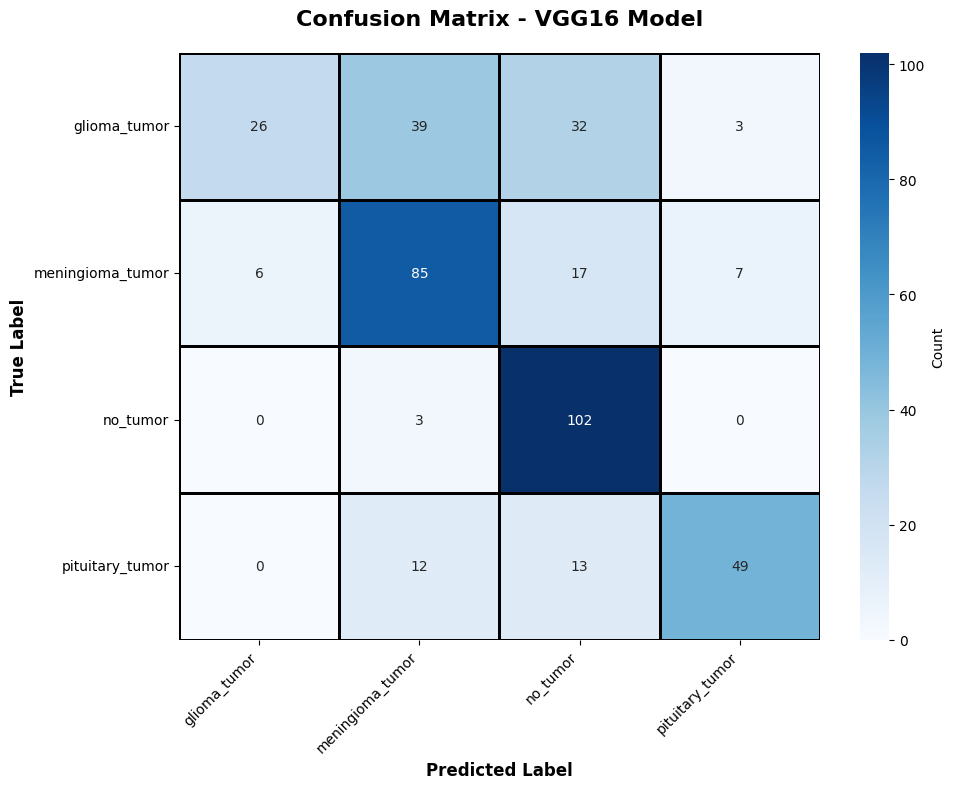


Confusion Matrix Analysis:

glioma_tumor:
  True Positives:  26
  False Positives: 6
  False Negatives: 74
  True Negatives:  288

meningioma_tumor:
  True Positives:  85
  False Positives: 54
  False Negatives: 30
  True Negatives:  225

no_tumor:
  True Positives:  102
  False Positives: 62
  False Negatives: 3
  True Negatives:  227

pituitary_tumor:
  True Positives:  49
  False Positives: 10
  False Negatives: 25
  True Negatives:  310


In [43]:
# Create and visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'}, linewidths=1, linecolor='black')
plt.title('Confusion Matrix - VGG16 Model', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontweight='bold', fontsize=12)
plt.xlabel('Predicted Label', fontweight='bold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print confusion matrix analysis
print("\n" + "="*60)
print("Confusion Matrix Analysis:")
print("="*60)

for i, class_name in enumerate(CLASS_NAMES):
    true_positives = conf_matrix[i, i]
    false_positives = conf_matrix[:, i].sum() - true_positives
    false_negatives = conf_matrix[i, :].sum() - true_positives
    true_negatives = conf_matrix.sum() - (true_positives + false_positives + false_negatives)

    print(f"\n{class_name}:")
    print(f"  True Positives:  {true_positives}")
    print(f"  False Positives: {false_positives}")
    print(f"  False Negatives: {false_negatives}")
    print(f"  True Negatives:  {true_negatives}")

Normalized Confusion Matrix

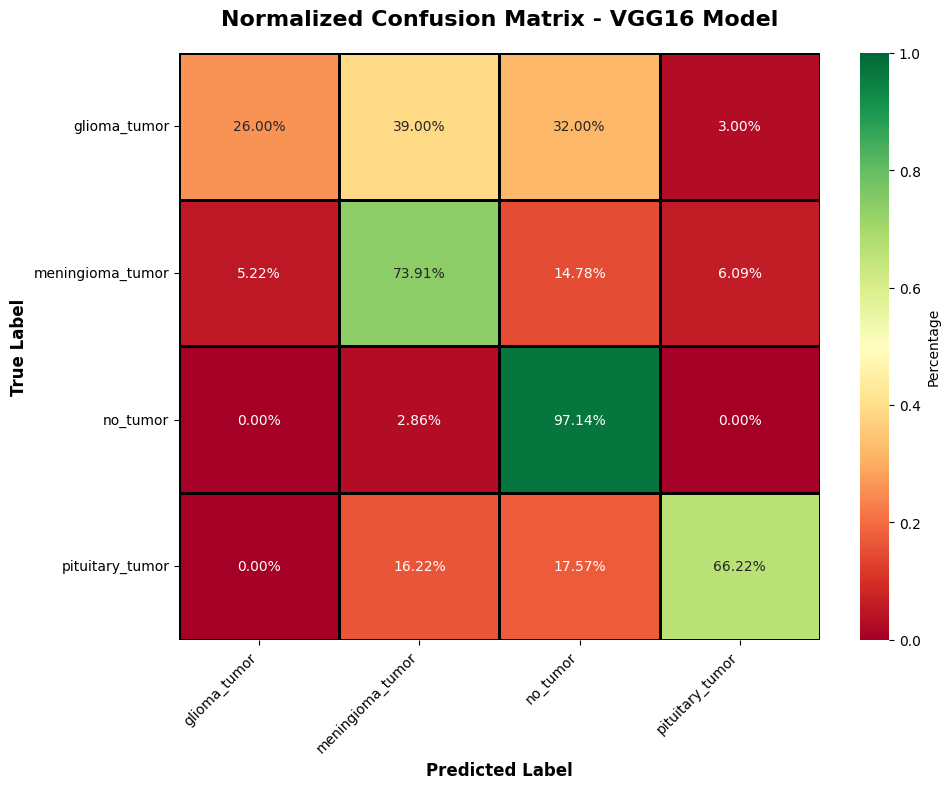

In [44]:
# Normalized confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='RdYlGn',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Percentage'}, linewidths=1, linecolor='black',
            vmin=0, vmax=1)
plt.title('Normalized Confusion Matrix - VGG16 Model', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontweight='bold', fontsize=12)
plt.xlabel('Predicted Label', fontweight='bold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Visualize Prediction Examples

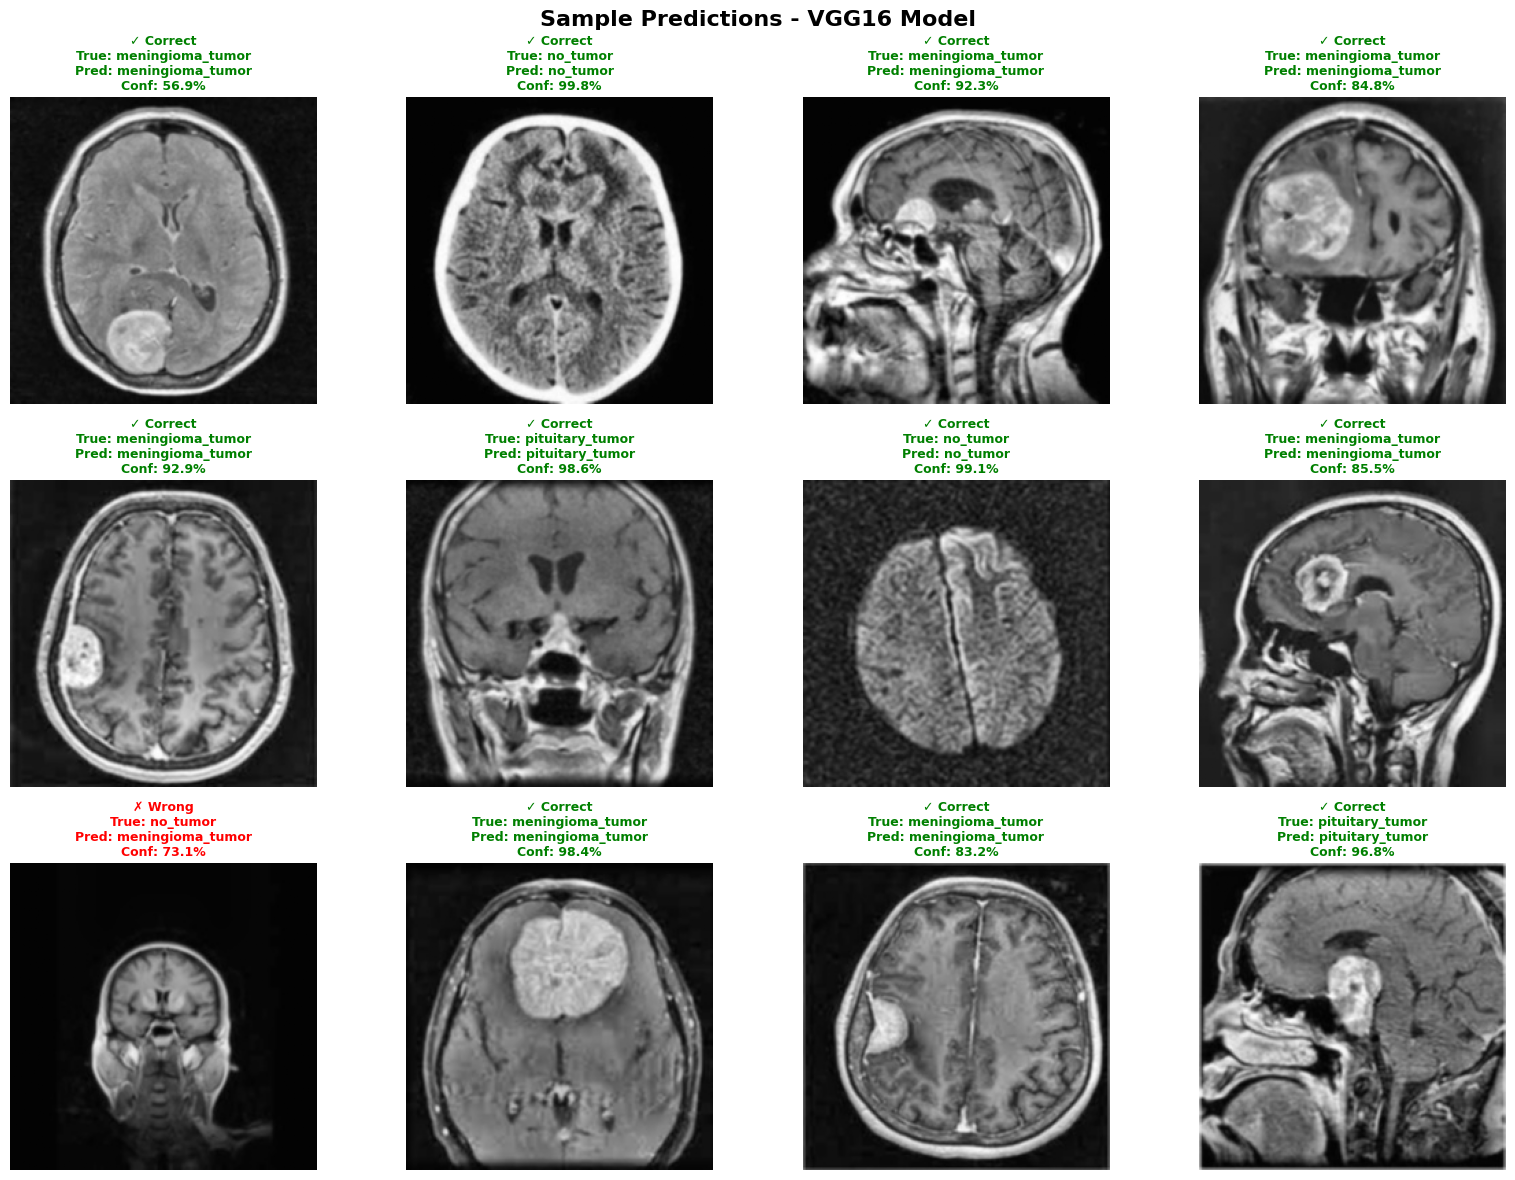

In [45]:
# Visualize prediction examples
def visualize_predictions(X, y_true, y_pred, y_pred_proba, num_samples=12):
    """
    Visualize sample predictions with probabilities
    """
    # Select random samples
    sample_indices = np.random.choice(len(X), num_samples, replace=False)

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle('Sample Predictions - VGG16 Model', fontsize=16, fontweight='bold')
    axes = axes.ravel()

    for i, idx in enumerate(sample_indices):
        img = X[idx]
        true_label = CLASS_NAMES[y_true[idx]]
        pred_label = CLASS_NAMES[y_pred[idx]]
        confidence = y_pred_proba[idx][y_pred[idx]] * 100

        # Display image
        axes[i].imshow(img)
        axes[i].axis('off')

        # Set title with color based on correctness
        if y_true[idx] == y_pred[idx]:
            color = 'green'
            title = f'✓ Correct'
        else:
            color = 'red'
            title = f'✗ Wrong'

        axes[i].set_title(f'{title}\nTrue: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
                         fontsize=9, fontweight='bold', color=color)

    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(X_test, y_test, y_pred, y_pred_proba, num_samples=12)

Per-Class Accuracy Analysis


PER-CLASS ACCURACY ANALYSIS
glioma_tumor             : 26.00% (26/100)
meningioma_tumor         : 73.91% (85/115)
no_tumor                 : 97.14% (102/105)
pituitary_tumor          : 66.22% (49/74)


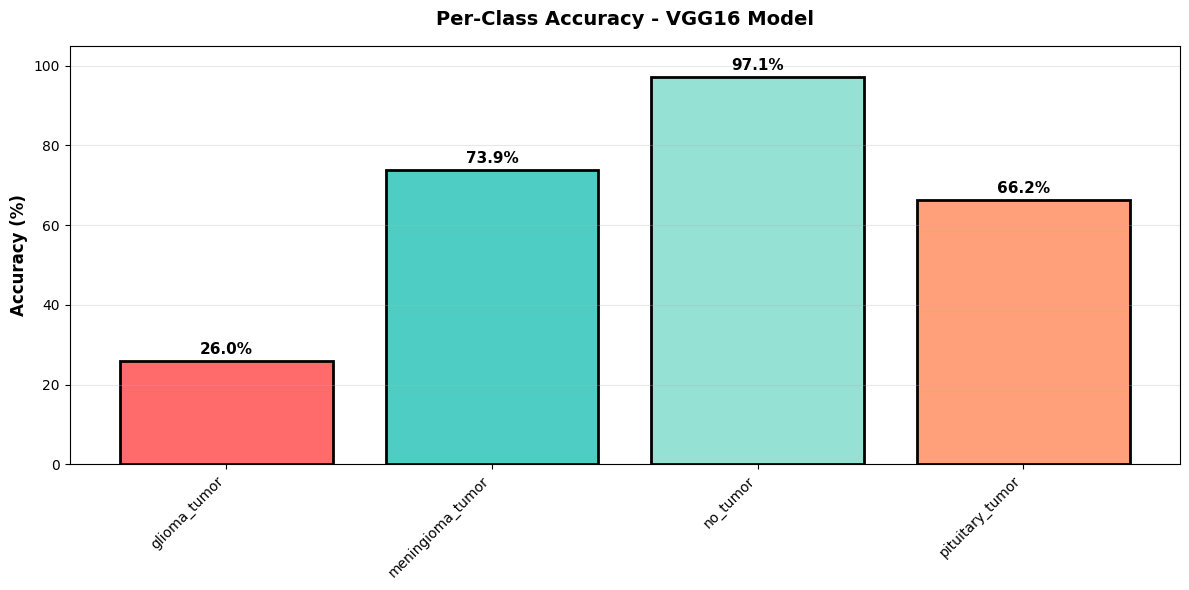

In [46]:
# Per-class accuracy analysis
print("\n" + "="*60)
print("PER-CLASS ACCURACY ANALYSIS")
print("="*60)

fig, ax = plt.subplots(figsize=(12, 6))

class_accuracies = []
for i, class_name in enumerate(CLASS_NAMES):
    class_mask = y_test == i
    class_correct = np.sum((y_test[class_mask] == y_pred[class_mask]))
    class_total = np.sum(class_mask)
    class_accuracy = (class_correct / class_total) * 100 if class_total > 0 else 0
    class_accuracies.append(class_accuracy)

    print(f"{class_name:25s}: {class_accuracy:.2f}% ({class_correct}/{class_total})")

# Plot per-class accuracies
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#FFA07A']
bars = ax.bar(CLASS_NAMES, class_accuracies, color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
ax.set_title('Per-Class Accuracy - VGG16 Model', fontweight='bold', fontsize=14, pad=15)
ax.set_ylim([0, 105])
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{class_accuracies[i]:.1f}%',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()